# 1. loading datasets

Training has to be done with dropout as data is not always present

In [76]:
import torch
import pandas as pd
import numpy as np
import time
import joblib
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F




In [77]:

from torch import nn 

# Check PyTorch version
print("PyTorch version:", torch.__version__)

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Get current CUDA device index (if available)
if torch.cuda.is_available():
    print("Current CUDA device index:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("No CUDA devices found.")



PyTorch version: 2.4.1+cpu
CUDA available: False
No CUDA devices found.


In [78]:
# Update with the correct path
# file_path = './Data/12_Sep_Readings/combined_data.csv'  
# file_path = './Data/15_Nov_Readings/augmented_rssi_dataset.csv'
file_path = './Data/15_Nov_Readings/combined_data.csv'
cleaned_df = pd.read_csv(file_path)

In [79]:
cleaned_df

,Tx_0 RSSI,Tx_0 Batt,Tx_0 Time,Tx_1 RSSI,Tx_1 Batt,Tx_1 Time,Tx_2 RSSI,Tx_2 Batt,Tx_2 Time,Tx_3 RSSI,...,Tx_5 Batt,Tx_5 Time,Tx_6 RSSI,Tx_6 Batt,Tx_6 Time,Tx_7 RSSI,Tx_7 Batt,Tx_7 Time,X_Coord,Y_Coord
0,-58,4.16,0.0,-65,4.13,0.0,-72,4.13,0.0,127,...,4.09,0.0,-81,4.12,0.0,-73,4.10,0.0,0,0
1,-59,4.11,21.0,-67,4.15,21.0,-72,4.11,20.0,-77,...,4.07,17.0,-80,4.12,15.0,-75,NaN,17.0,0,0
2,-59,4.14,38.0,-67,4.14,38.0,-73,NaN,40.0,-77,...,4.08,40.0,-79,4.13,38.0,-76,4.11,35.0,0,0
3,-60,4.16,57.0,-68,4.13,57.0,-73,4.12,56.0,-70,...,4.07,54.0,-83,4.13,50.0,-76,NaN,51.0,0,0
4,-60,4.16,74.0,-68,4.13,74.0,-73,4.11,72.0,-70,...,NaN,79.0,-81,4.14,78.0,-76,NaN,79.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,-74,NaN,357.0,-66,NaN,358.0,-67,4.07,357.0,-54,...,4.00,357.0,-76,4.11,352.0,-77,4.06,347.0,5,6
1275,-73,4.11,373.0,-67,4.10,368.0,-67,4.08,368.0,-54,...,4.00,376.0,-75,4.10,373.0,-77,4.07,367.0,5,6
1276,-73,4.11,394.0,-67,NaN,394.0,-68,NaN,398.0,-54,...,4.01,402.0,-75,4.11,397.0,-78,4.06,392.0,5,6
1277,-73,4.02,419.0,-67,4.11,415.0,-68,4.08,415.0,-53,...,4.01,419.0,-74,4.11,415.0,-78,4.06,409.0,5,6


In [80]:

batt_columns = [col for col in cleaned_df.columns if 'Batt' in col]
time_columns = [col for col in cleaned_df.columns if 'Time' in col]
columns_to_drop = batt_columns+time_columns
RSSI_columns = cleaned_df.drop(columns=columns_to_drop)







cleaned_df.shape

(1279, 26)

In [81]:
cleaned_df

,Tx_0 RSSI,Tx_0 Batt,Tx_0 Time,Tx_1 RSSI,Tx_1 Batt,Tx_1 Time,Tx_2 RSSI,Tx_2 Batt,Tx_2 Time,Tx_3 RSSI,...,Tx_5 Batt,Tx_5 Time,Tx_6 RSSI,Tx_6 Batt,Tx_6 Time,Tx_7 RSSI,Tx_7 Batt,Tx_7 Time,X_Coord,Y_Coord
0,-58,4.16,0.0,-65,4.13,0.0,-72,4.13,0.0,127,...,4.09,0.0,-81,4.12,0.0,-73,4.10,0.0,0,0
1,-59,4.11,21.0,-67,4.15,21.0,-72,4.11,20.0,-77,...,4.07,17.0,-80,4.12,15.0,-75,NaN,17.0,0,0
2,-59,4.14,38.0,-67,4.14,38.0,-73,NaN,40.0,-77,...,4.08,40.0,-79,4.13,38.0,-76,4.11,35.0,0,0
3,-60,4.16,57.0,-68,4.13,57.0,-73,4.12,56.0,-70,...,4.07,54.0,-83,4.13,50.0,-76,NaN,51.0,0,0
4,-60,4.16,74.0,-68,4.13,74.0,-73,4.11,72.0,-70,...,NaN,79.0,-81,4.14,78.0,-76,NaN,79.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,-74,NaN,357.0,-66,NaN,358.0,-67,4.07,357.0,-54,...,4.00,357.0,-76,4.11,352.0,-77,4.06,347.0,5,6
1275,-73,4.11,373.0,-67,4.10,368.0,-67,4.08,368.0,-54,...,4.00,376.0,-75,4.10,373.0,-77,4.07,367.0,5,6
1276,-73,4.11,394.0,-67,NaN,394.0,-68,NaN,398.0,-54,...,4.01,402.0,-75,4.11,397.0,-78,4.06,392.0,5,6
1277,-73,4.02,419.0,-67,4.11,415.0,-68,4.08,415.0,-53,...,4.01,419.0,-74,4.11,415.0,-78,4.06,409.0,5,6


In [82]:
from common_utils import preprocess_dataset

X = cleaned_df[['Tx_0 RSSI', 'Tx_1 RSSI', 'Tx_2 RSSI', 'Tx_3 RSSI', 'Tx_4 RSSI', 'Tx_5 RSSI', 'Tx_6 RSSI', 'Tx_7 RSSI']]
# X = cleaned_df[['Tx_0 RSSI_Avg', 'Tx_1 RSSI_Avg', 'Tx_2 RSSI_Avg', 'Tx_3 RSSI_Avg', 'Tx_4 RSSI_Avg', 'Tx_5 RSSI_Avg', 'Tx_6 RSSI_Avg', 'Tx_7 RSSI_Avg']]


Y = cleaned_df[['X_Coord', 'Y_Coord']]

# Perform the train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Display the results
print("X_train:\n", X_train)
print("X_test:\n", X_test)
print("Y_train:\n", Y_train)
print("Y_test:\n", Y_test)

X_train:
       Tx_0 RSSI  Tx_1 RSSI  Tx_2 RSSI  Tx_3 RSSI  Tx_4 RSSI  Tx_5 RSSI  \
351         -68        -60        -64        -69        -74        -73   
673         -79        -69        -70        -58        -59        -65   
741         -80        -67        -79        -63        -73        -58   
781         -77        -74        -75        -59        -55        -71   
158         -68        -68        -70        -70        -71        -82   
...         ...        ...        ...        ...        ...        ...   
1044        -71        -60        -67        -65        -78        -71   
1095        -84        -71        -75        -59        -78        -73   
1130        -70        -69        -80        -64        -68        -71   
860         -69        -60        -64        -62        -68        -67   
1126        -70        -69        -79        -63        -69        -82   

      Tx_6 RSSI  Tx_7 RSSI  
351         -84        -75  
673         -63        -71  
741         -6

In [83]:
# We plot a heatmap of RSSI strength vs Transmitters, and you have 
# A new heatmap for each location?

max_samples = 20  # Number of samples to include for each location
num_transmitters = 8

location_groups = cleaned_df.groupby(['X_Coord', 'Y_Coord'])

# Initialize a list to store the heatmap data for the CNN
cnn_input_data = []
cnn_labels = []  # This will hold the corresponding coordinates (X_Coord, Y_Coord) or labels

# Iterate through each location and extract RSSI values
for location, group in location_groups:
    # Extract RSSI values (transmitters as rows, samples as columns)
    rssi_values = group[['Tx_0 RSSI', 'Tx_1 RSSI', 'Tx_2 RSSI', 'Tx_3 RSSI',
                         'Tx_4 RSSI', 'Tx_5 RSSI', 'Tx_6 RSSI', 'Tx_7 RSSI']].values.T
    
    # Normalize the RSSI values to a range between 0 and 1 using MinMaxScaler
    scaler = MinMaxScaler()
    rssi_values_normalized = scaler.fit_transform(rssi_values)
    
    # Add the normalized heatmap to the CNN input data
    cnn_input_data.append(rssi_values_normalized)
    
    # Optionally, add the corresponding location labels (e.g., X_Coord, Y_Coord) as the target for classification
    cnn_labels.append(location)

# Find the maximum number of samples (columns) across all locations
max_samples = max([rssi.shape[1] for rssi in cnn_input_data])

# Manually pad each heatmap to have the same number of columns (samples)
padded_cnn_input_data = []
for rssi_values in cnn_input_data:
    # Calculate the padding required
    padding_length = max_samples - rssi_values.shape[1]
    
    # Pad the data with zeros (or any other constant value)
    padded_rssi_values = np.pad(rssi_values, ((0, 0), (0, padding_length)), mode='constant', constant_values=0)
    
    # Add the padded heatmap to the list
    padded_cnn_input_data.append(padded_rssi_values)

# Convert the list to a numpy array
cnn_input_data = np.array(padded_cnn_input_data)
cnn_labels = np.array(cnn_labels)

# cnn_input_data is now a 3D array where each "image" is a heatmap for a location
# Shape: (num_locations, num_transmitters, max_samples)

print(f"Input data shape for CNN: {cnn_input_data.shape}")
print(f"Labels shape: {cnn_labels.shape}")




Input data shape for CNN: (64, 8, 20)
Labels shape: (64, 2)


# 2. NN model

In [84]:
class CNN(nn.Module):
    def __init__(self, num_transmitters, max_samples):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Convolution layer 1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Convolution layer 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Convolution layer 3
        
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        
        # Calculate the flattened size after the convolution and pooling layers
        self.flattened_size = 128 * (max_samples // 8) * (num_transmitters // 8)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)  # Output layer (X_Coord, Y_Coord)

    def forward(self, x):
        # Apply convolutional layers with ReLU activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        
        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Final output (X_Coord, Y_Coord)

        
        return x

In [85]:
model = CNN(num_transmitters=8, max_samples=20)

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [90]:
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)


In [86]:
cnn_input_data = torch.tensor(cnn_input_data, dtype=torch.float32).unsqueeze(1)  # Add a channel dimension
cnn_labels = torch.tensor(cnn_labels, dtype=torch.float32)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(cnn_input_data, cnn_labels, test_size=0.2, random_state=42)


In [87]:
# Parameters for early stopping
patience = 50  # Number of epochs to wait for improvement in validation loss
best_val_loss = float('inf')  # Initialize best validation loss to a large value
epochs_without_improvement = 0  # Counter for epochs without improvement

num_epochs = 1000
train_losses = []
val_losses = []
val_accuracies = []  # Track validation accuracy

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    optimizer.zero_grad()  # Zero the gradients

    # Forward pass for training
    outputs = model(X_train)
    loss = criterion(outputs, y_train)  # Calculate train loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update model parameters

    # Validation Phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)  # Calculate validation loss

        # Compute accuracy
        predicted_coords = torch.round(val_outputs).to(torch.int)  # Round predictions
        correct_predictions = (predicted_coords == y_test.to(torch.int)).all(dim=1)
        val_accuracy = correct_predictions.sum().item() / y_test.size(0) * 100

    # Track losses and accuracy
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss  # Update best validation loss
        epochs_without_improvement = 0  # Reset counter
    else:
        epochs_without_improvement += 1  # Increment counter if no improvement

    # If validation loss hasn't improved for 'patience' epochs, stop training
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

    # Print metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {loss.item():.4f}, "
              f"Val Loss: {val_loss.item():.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%")


Epoch [10/1000], Train Loss: 6.5755, Val Loss: 5.8483, Val Accuracy: 7.69%
Epoch [20/1000], Train Loss: 5.7201, Val Loss: 6.9438, Val Accuracy: 0.00%
Epoch [30/1000], Train Loss: 5.1284, Val Loss: 5.7861, Val Accuracy: 7.69%
Epoch [40/1000], Train Loss: 4.9857, Val Loss: 5.5914, Val Accuracy: 0.00%
Epoch [50/1000], Train Loss: 4.6952, Val Loss: 5.5512, Val Accuracy: 7.69%
Epoch [60/1000], Train Loss: 4.3864, Val Loss: 5.7140, Val Accuracy: 7.69%
Early stopping triggered at epoch 67.


In [88]:
# Set model to evaluation mode
model.eval()

# Choose a sample input from the test set
# Assuming you have already split your data into X_test (input) and y_test (targets)
inputs, targets = X_test, y_test  # Replace X_test, y_test with your actual test set

# Select only the first 10 samples from the batch
inputs = inputs[:10]
actual_targets = targets[:10]  # Corresponding actual coordinates for the test set

# Reshape inputs to fit the model (if needed)
# inputs = inputs.unsqueeze(1)  # Add channel dimension, shape: (10, 1, 8, 20)

# Perform the forward pass
with torch.no_grad():
    # Forward pass to get the model's predictions
    preds = model(inputs)  # Output shape: (10, 2) for X_Coord and Y_Coord predictions

predicted_coords = torch.round(preds).to(torch.int)
# Display predicted coordinates (X, Y) and actual targets
print("Predicted X and Y coordinates:")
print(predicted_coords.numpy())  

print("\nActual X and Y coordinates:")
print(actual_targets.numpy()) 


Predicted X and Y coordinates:
[[4 4]
 [5 5]
 [2 3]
 [4 4]
 [4 4]
 [4 4]
 [4 4]
 [4 4]
 [4 4]
 [3 3]]

Actual X and Y coordinates:
[[6. 4.]
 [7. 2.]
 [0. 0.]
 [5. 4.]
 [0. 5.]
 [4. 4.]
 [2. 0.]
 [1. 4.]
 [3. 1.]
 [7. 5.]]


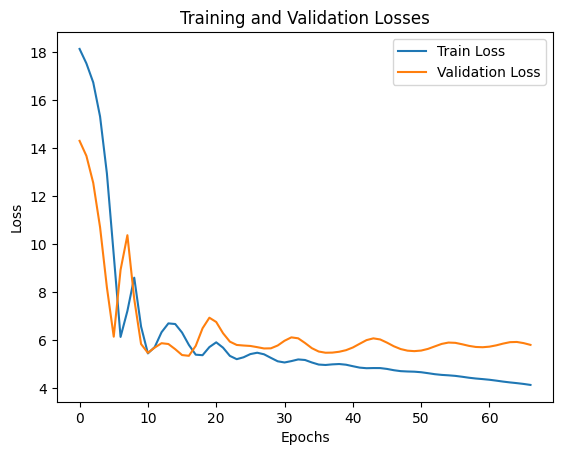

In [89]:
# Plot training and validation losses up to the point where early stopping was triggered
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()
